# Modeling 

Let's try to train some model to predict needs of clients. As we have seen, we now have a dataset with 5 feature. This is not a lot so we can train complex model without to much cost and doing overfiting. 

To do so, we have choosen particularly two model : RF and ANN. 

The first one is because it is a ensemble of tree which is maximizing the prediction capacities. And manually, in this problem, we would have done a process of sorting data regarding some value : it's exactly a random forest. Thus, we found this model well fit and hop it will have good perfomance

The second is because of ANN could match up with whatever function we are searching. The need isn't writtable easily thus the objective function must be complicated (non linear for sur) so we expect that ANN will help us with this complexity.

In [2]:
# Classical libraries
import numpy as np
import pandas as pd
import sklearn
from scipy.stats import zscore

In [56]:
# load data and verify none data
dataset = pd.read_excel('Needs.xls', index_col=0)
np.any(np.isnan(dataset.values))
# log transformation as we have seen and drop of the feature we don't want
logIncome = np.log(dataset[["Income"]].values)
logWealth = np.log(dataset[["Wealth"]].values)
dataset["logIncome"] = logIncome
dataset["logWealth"] = logWealth
dataset = dataset.drop(["Income", "Wealth", "Gender", "FamilyMembers" ], axis=1)

#we convert it into a numpay array
data = dataset[["Age", "FinancialEducation", "RiskPropensity", "logIncome", "logWealth"]].values
#we store mean and std before use z-score scaler
data_mean = np.mean(data, axis=0)
data_std = np.std(data, axis=0)
X =  zscore(data) # scale data

# we store the target
t_inc = dataset['IncomeInvestment'].values == 1
t_acc = dataset['AccumulationInvestment'].values == 1


#Create the subsets
from sklearn.model_selection import train_test_split

#Train = 70 % ; Test = 15 % ; Validation = 15 %
indices = np.arange(np.shape(dataset)[0])

X_train, X_test, Inc_train, Inc_test, Acc_train, Acc_test, indices_train, indices_test = train_test_split(X, t_inc, t_acc, indices, test_size=0.1, shuffle=True, random_state=0) #Test and Train sets






(4500,) (4500, 5)


In [4]:
#Models libraries
from sklearn.ensemble import RandomForestClassifier as RF 
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

from sklearn.metrics import confusion_matrix
import seaborn as sns


2022-05-18 09:14:30.247399: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-18 09:14:30.247434: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [38]:
def valueModel(model, isInc=1):
    if isInc:
        print("Accuracy mean for train : ", model.score(X_train, Inc_train), " Accuracy mean for validation = ", model.score(X_train, Inc_train))
    else:
        print("Accuracy : ", model.score(X_train, Acc_train), " Score = ", model.score(X_train, Acc_train))

def confusionMat(prediction, isInc=1, plot=False):
    if isInc:
        cm = confusion_matrix(Inc_test, prediction)
    else:
        cm = confusion_matrix(Acc_test, prediction)
    if not plot: print(cm)
    if plot:
        group_names = ["True Neg","False Pos","False Neg","True Pos"]
        group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
        sns.heatmap(cm, annot=labels, fmt="", cmap='Blues')
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0] 
    TP = cm[1][1]
    TPR = TP/(TP+FN) ; P = TP/(TP+FP) 
    TNR = (TN/(TN+FP)) ; F1 = (2*P*TPR)/(P+TPR)
    acc = (TP+TN)/(TP+TN+FP+FN)
    print("Measures:")
    print(f'Sensitivity = {TPR:2.2%} ;  Specificity = {TNR:2.2%} ; Precision = {P:2.2%} ; F1 score = {F1:2.2%} ; Accuracy = {acc:2.2%}')
    print()

In [39]:
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ConfusionMatrix
def objective(train, test):
    rf = RF()
    classes = ["no need", "need"]
    
    visualizer = ClassPredictionError(
                    rf, classes=classes)

    # Fit the training data to the visualizer
    visualizer.fit(train[0], train[1])

    # Evaluate the model on the test data
    visualizer.score(test[0], test[1])

    # Draw visualization
    visualizer.show()

Let's first train the models in the standard way, without optimization, to see some result 

RF model for Inc : 
Measures:
Sensitivity = 56.63% ;  Specificity = 92.76% ; Precision = 83.46% ; F1 score = 67.48% ; Accuracy = 78.60%



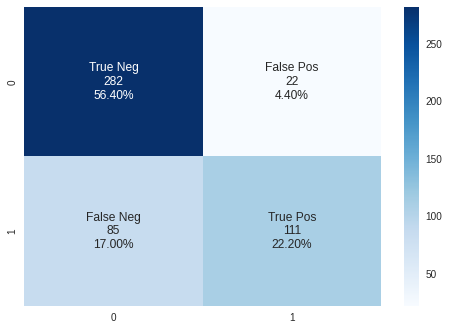

In [42]:
#Random Forest
rfModInc, rfModAcc = RF(), RF()
rfModInc.fit(X_train, Inc_train)
rfModAcc.fit(X_train, Acc_train)

predRFInc = rfModInc.predict(X_test)
predRFAcc = rfModAcc.predict(X_test)

print("RF model for Inc : ")
confusionMat(predRFInc, plot=True)


RF model for Acc : 
Measures:
Sensitivity = 72.22% ;  Specificity = 86.09% ; Precision = 85.90% ; F1 score = 78.47% ; Accuracy = 78.60%



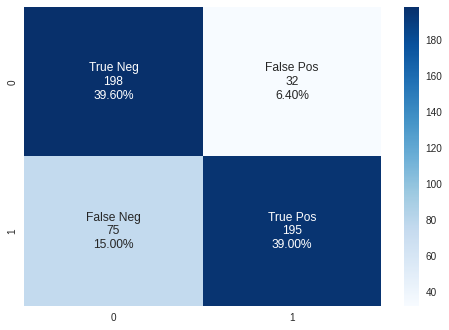

In [43]:
print("RF model for Acc : ")
confusionMat(predRFAcc,0, plot=True)

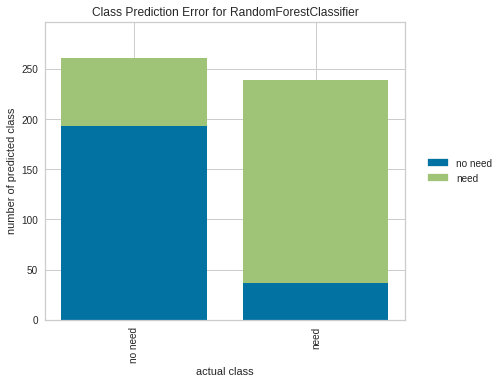

In [44]:
objective([X_train, Acc_train], [X_test, Acc_test])
# objective([X_train, Acc_train], [X_val, Acc_val]) but result are similar

As we can see, score a quite good with this model. But we want to minimize false negative prediction : a client with a need must receive product proposal from our part. Thus we need to maximize the sensitivity (maximize the rest is also the goal, we search a good tradeoff)

So let's optimize this model. 

In [45]:
from sklearn.model_selection import RandomizedSearchCV

#Random Forest
paramGrid = {'bootstrap': [True, False],
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 5, 10, 30, 50, 70],
            'max_features': ['sqrt','auto', 'log2'],
            'n_estimators': [50, 100, 300],
            #'n_features': [4,5,6,7],
            'warm_start': [False, True]}
rf_randomInc = RandomizedSearchCV(estimator = RF(n_jobs=-1), n_iter=50, param_distributions = paramGrid, n_jobs = -1, verbose=0)
rf_randomInc.fit(X_train, Inc_train)
rf_randomAcc = RandomizedSearchCV(estimator = RF(n_jobs=-1), n_iter=50, param_distributions = paramGrid, n_jobs = -1, verbose=0)
rf_randomAcc.fit(X_train, Acc_train)
rfIncMod = rf_randomInc.best_estimator_
rfAccMod = rf_randomAcc.best_estimator_

In [46]:
print(rfIncMod.get_params())
print("\n", rfAccMod.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

 {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 30, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': True}


In [47]:
predACC = rfModAcc.predict(X_test)
predINC = rfIncMod.predict(X_test)

RF model for opti Acc : 
Measures:
Sensitivity = 72.22% ;  Specificity = 86.09% ; Precision = 85.90% ; F1 score = 78.47% ; Accuracy = 78.60%



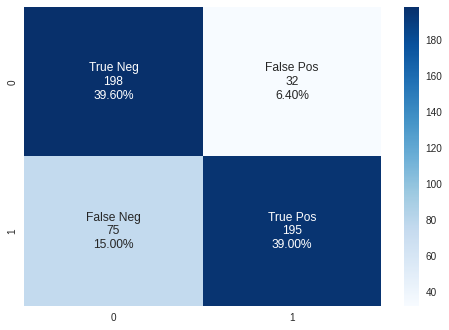

In [48]:
print("RF model for opti Acc : ")
confusionMat(predACC,0, plot=True)

RF model for opti Acc : 
Measures:
Sensitivity = 56.12% ;  Specificity = 93.42% ; Precision = 84.62% ; F1 score = 67.48% ; Accuracy = 78.80%



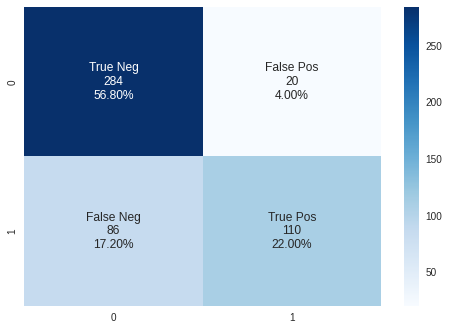

In [49]:
print("RF model for opti Acc : ")
confusionMat(predINC,1, plot=True)

In [57]:
#cross validation
#Random Forest>>> 
from sklearn.model_selection import cross_validate
def cross_validation(model, train, target, cond):
    

    metrics = ['accuracy', 'f1', 'recall', 'precision']
    scores = cross_validate(model, train, target,
                            scoring=metrics,
                            return_train_score=True)

    tests = ['test_accuracy','test_f1','test_recall','test_precision']
    for metric in range(len(tests)):
        evaluate = scores[tests[metric]]
        #print(evaluate)
        print("mean of %0.2f %s with a standard deviation of %0.2f for %s " % (evaluate.mean(),metrics[metric], evaluate.std(), tests[metric]))

In [36]:
from sklearn.model_selection import cross_val_predict

def prediction_CV(model, train, target, description):
    if description :
        cross_validation(model, train, target)
    return cross_val_predict(model, train, target)

accu 
vs 
inc 
RF model for cross val Acc : 
Measures:
Sensitivity = 74.81% ;  Specificity = 70.43% ; Precision = 74.81% ; F1 score = 74.81% ; Accuracy = 72.80%



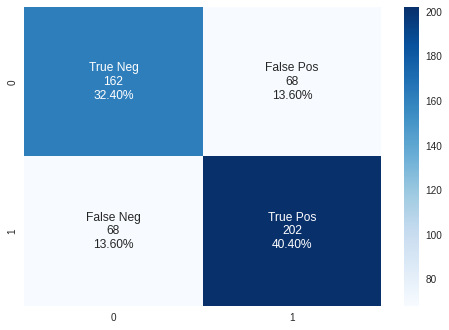

In [61]:
rfacctest = RF()
rfinctest = RF()

predAcc = prediction_CV(rfacctest, X_test, Acc_test, False)
print("accu \nvs \ninc ")
predInc = prediction_CV(rfinctest, X_test, Inc_test, False)

print("RF model for cross val Acc : ")
confusionMat(predAcc,0, plot=True)



RF model for cross val Inc : 
Measures:
Sensitivity = 57.65% ;  Specificity = 87.50% ; Precision = 74.83% ; F1 score = 65.13% ; Accuracy = 75.80%



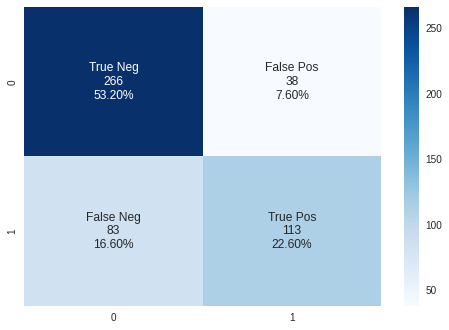

In [43]:
print("RF model for cross val Inc : ")
confusionMat(predInc,1, plot=True)

Measures:
Sensitivity = 64.44% ;  Specificity = 92.17% ; Precision = 90.62% ; F1 score = 75.32% ; Accuracy = 77.20%



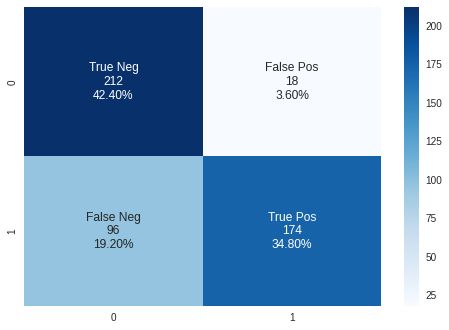

In [90]:
model = RF()

estimator = cross_validate(model, X_train, Acc_train,
                            scoring="recall",cv=10
                            , return_estimator=True)

folders = estimator['estimator']
pred = [0 for i in range(len(Acc_test))]
for i in range(len(folders)):
    pred += estimator['estimator'][i].predict(X_test)
pred = pred // (len(folders))

confusionMat(pred, 0, plot=True)

Measures:
Sensitivity = 56.63% ;  Specificity = 93.42% ; Precision = 84.73% ; F1 score = 67.89% ; Accuracy = 79.00%



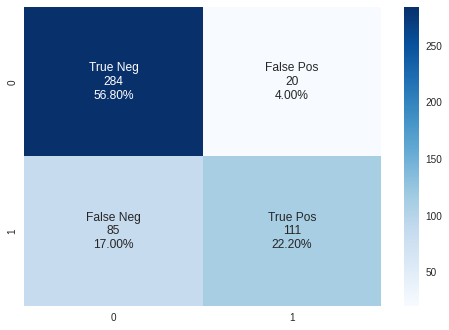

In [93]:
model = RF()

estimator = cross_validate(model, X_train, Inc_train,
                            scoring="recall",cv=10
                            , return_estimator=True)

folders = estimator['estimator']
pred = [0 for i in range(len(Inc_test))]
for i in range(len(folders)):
    pred += estimator['estimator'][i].predict(X_test)
pred = pred // (len(folders))

confusionMat(pred, 1, plot=True)